## BBM 409 - Programming Assignment 4

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Yusuf Demir 221035074

## Understanding LSTM's with Sentiment Analysis (100 points)

### 1. Data Loading and Exploration (5 points)
* Brief overview of the task.
* Description of the dataset used for analysis.

- **Task Overview**: The objective is to perform sentiment analysis on the IMDB dataset by classifying movie reviews as positive or negative. This involves preparing the dataset, conducting exploratory data analysis (EDA), and extracting insights to inform the preprocessing and modeling steps.
  
- **Dataset Description**: 
  - The dataset contains 10,000 samples of movie reviews and their corresponding sentiment labels (0 for negative and 1 for positive).
  - Each review is represented as a text string, and the sentiment is represented as a binary integer.

In [378]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.decomposition import PCA

import os

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torch.optim as optim

In [379]:
# Load the data into pandas a dataframe
# Represent the sentiments in a meaningful numerical form
# Check the first few rows

# Load the dataset into a pandas dataframe
df = pd.read_csv("./subset10000_IMDB_Dataset.csv")

# Represent the sentiments in a meaningful numerical form
# Assuming the 'sentiment' column contains 'positive' and 'negative', map them to 1 and 0 respectively
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Display the first few rows to understand the structure of the dataset
print("First few rows of the dataset:")
print(df.head())


First few rows of the dataset:
                                              review  sentiment
0  Starts really well, nice intro and build up fo...          0
1  Terrific movie: If you did not watch yet, you ...          1
2  I've seen hundreds of silent movies. Some will...          1
3  i had been looking for this film for so long b...          1
4  Good: Engaging cinematic firefights, great pre...          1


In [380]:
## Explore the dataset (e.g., size, features, target variables, summary statistics).
## Check for any missing values and handle them if necessary.

# Explore the dataset (e.g., size, features, target variables, summary statistics)
print("\nDataset information:")
df.info()

print("\nSummary statistics for numerical columns:")
print(df.describe())

# Check for any missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

# Data distribution: Count the number of positive and negative sentiments
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())

# Analyze the length of the reviews
df['review_length'] = df['review'].apply(len)
print("\nSummary of review lengths:")
print(df['review_length'].describe())

# Optional: If computational resources are limited, take a subset of the data for analysis
# For instance, select 10,000 random samples
subset_df = df.sample(n=10000, random_state=42)
print(f"\nSubset size: {subset_df.shape[0]} rows")

# Save the subset for later use
subset_df.to_csv("imdb_reviews_subset.csv", index=False)

# Observations based on EDA:
# - The dataset contains X rows and Y columns.
# - The sentiment distribution shows that the dataset is balanced/unbalanced.
# - The average review length is approximately Z characters.


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB

Summary statistics for numerical columns:
          sentiment
count  10000.000000
mean       0.500000
std        0.500025
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000

Missing values in the dataset:
review       0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
0    5000
1    5000
Name: count, dtype: int64

Summary of review lengths:
count    10000.000000
mean      1305.738500
std        989.640769
min         51.000000
25%        698.000000
50%        966.000000
75%       1602.000000
max       9345.000000
Name: review_length, dtype: float64

Subset size: 10000 rows


### General Observations and Insights
- **Class Balance**: The dataset is balanced, with an equal number of positive (1) and negative (0) sentiments. This is advantageous for model training as it prevents bias towards any particular class.
- **Review Length**: The variability in review length should be addressed during text preprocessing. For instance, excessively long reviews can be truncated, and very short reviews may need augmentation.
- **Missing Data**: The absence of missing values simplifies the data cleaning process, allowing us to proceed directly to model development.

### 2. Preprocessing the Data (10 points)

In [381]:
# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/demir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/demir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/demir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/demir/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [382]:
# Initialize a tokenizer and lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# An example function for prepocess the texts and create the tokens, you can improve it to clean the texts more accurately
# Function to preprocess text
def preprocess_text(text):
    # Replace slashes and other separators with spaces
    text = re.sub(r'[/\\]', ' ', text)
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters except spaces
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

In [383]:
# Add a tokens column to the dataframe to store preprocessed tokens
# Build the vocabulary using the tokens
# Assign indices to each token in the vocabulary
# Reserve 0 for padding

# Apply preprocessing to reviews
df['tokens'] = df['review'].apply(preprocess_text)

# Build a tokenizer and fit it on the tokens
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'])

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 73250


In [384]:
# Calculate the length of each review from the tokenized version
# Display statistical details about review lengths
# Decide padding length considering these stats
# Remember we don't want padded zeros to overcome meaningful information in the sequence

# Convert tokens to sequences of indices
df['indices'] = tokenizer.texts_to_sequences(df['tokens'])

# Calculate review lengths
df['review_length'] = df['indices'].apply(len)

# Display review length statistics
print(df['review_length'].describe())

# Define a padding length based on the 90th percentile of review lengths
padding_length = int(df['review_length'].quantile(0.9))
print(f"Padding Length: {padding_length}")

count    10000.000000
mean       118.347200
std         89.271519
min          4.000000
25%         64.000000
50%         88.000000
75%        145.000000
max        804.000000
Name: review_length, dtype: float64
Padding Length: 231


To ensure all sequences have the same length, we padded shorter sequences with zeros. The padding length was determined based on the 90th percentile of review lengths. This choice ensures that most reviews retain their meaningful information while minimizing the impact of padded zeros. By avoiding excessive padding, we reduce the risk of zeros dominating the sequences, which could negatively affect the model's performance. Statistical analysis of review lengths guided this decision to balance efficiency and information preservation.

In [385]:
df.head()

,review,sentiment,review_length,tokens,indices
0,"Starts really well, nice intro and build up fo...",0,79,"[start, really, well, nice, intro, build, main...","[136, 14, 18, 225, 4579, 1177, 175, 6, 94, 104..."
1,"Terrific movie: If you did not watch yet, you ...",1,24,"[terrific, movie, watch, yet, must, watch, gee...","[1154, 1, 34, 152, 125, 34, 11166, 1528, 4208,..."
2,I've seen hundreds of silent movies. Some will...,1,61,"[ive, seen, hundred, silent, movie, always, cl...","[116, 41, 1739, 1058, 1, 117, 237, 13263, 1032..."
3,i had been looking for this film for so long b...,1,78,"[looking, film, long, found, seen, younger, lo...","[194, 2, 114, 156, 41, 850, 306, 205, 612, 53,..."
4,"Good: Engaging cinematic firefights, great pre...",1,92,"[good, engaging, cinematic, firefights, great,...","[7, 1640, 1210, 23279, 19, 2452, 1587, 72, 150..."


In [386]:
# Convert review tokens to indices and add an indices column to the dataframe to store
# Represent each token in the dataset with its corresponding index from the vocabulary
# Ensure all sequences have the same length by padding shorter sequences with zeros
# Pad the token indices version of review sequences

# Function to pad sequences
def pad_sequence(seq, max_len):
    return pad_sequences([seq], maxlen=max_len, padding='post')[0]

# Pad sequences and add them to the dataframe
df['padded_indices'] = df['indices'].apply(lambda x: pad_sequence(x, padding_length))

# Convert the padded indices into a tensor
padded_indices = np.array(df['padded_indices'].tolist())
# Define sentiment labels (assuming df['label'] contains 0 for negative and 1 for positive reviews)
sentiment_labels = df['sentiment'].values

print(df.head())

# Add an padded_indices column to store padded sequences

                                              review  sentiment  \
0  Starts really well, nice intro and build up fo...          0   
1  Terrific movie: If you did not watch yet, you ...          1   
2  I've seen hundreds of silent movies. Some will...          1   
3  i had been looking for this film for so long b...          1   
4  Good: Engaging cinematic firefights, great pre...          1   

   review_length                                             tokens  \
0             79  [start, really, well, nice, intro, build, main...   
1             24  [terrific, movie, watch, yet, must, watch, gee...   
2             61  [ive, seen, hundred, silent, movie, always, cl...   
3             78  [looking, film, long, found, seen, younger, lo...   
4             92  [good, engaging, cinematic, firefights, great,...   

                                             indices  \
0  [136, 14, 18, 225, 4579, 1177, 175, 6, 94, 104...   
1  [1154, 1, 34, 152, 125, 34, 11166, 1528, 4208,...   
2 

In [387]:
# Check the length of the every indices

for i in range(5): 
    print(len(df['indices'][i]))

79
24
61
78
92


In [388]:
# Check the length of the some padded_indices

# Check the first few rows of the dataframe
for i in range(5):
    print(f"Review {i + 1} Length: {len(df['padded_indices'][i])}")

Review 1 Length: 231
Review 2 Length: 231
Review 3 Length: 231
Review 4 Length: 231
Review 5 Length: 231


In [389]:
print(df['indices'].head(100))

0     [136, 14, 18, 225, 4579, 1177, 175, 6, 94, 104...
1     [1154, 1, 34, 152, 125, 34, 11166, 1528, 4208,...
2     [116, 41, 1739, 1058, 1, 117, 237, 13263, 1032...
3     [194, 2, 114, 156, 41, 850, 306, 205, 612, 53,...
4     [7, 1640, 1210, 23279, 19, 2452, 1587, 72, 150...
                            ...                        
95    [1272, 306, 1, 33, 3715, 31948, 84, 115, 979, ...
96    [1436, 7094, 3052, 3424, 56, 7, 68, 2520, 82, ...
97    [848, 241, 2581, 1512, 681, 241, 462, 4107, 16...
98    [115, 3, 500, 3233, 161, 2, 90, 21, 505, 14773...
99    [87, 755, 4, 3, 688, 124, 52, 31973, 7070, 916...
Name: indices, Length: 100, dtype: object


In [390]:
print(df['padded_indices'].head(100))

0     [136, 14, 18, 225, 4579, 1177, 175, 6, 94, 104...
1     [1154, 1, 34, 152, 125, 34, 11166, 1528, 4208,...
2     [116, 41, 1739, 1058, 1, 117, 237, 13263, 1032...
3     [194, 2, 114, 156, 41, 850, 306, 205, 612, 53,...
4     [7, 1640, 1210, 23279, 19, 2452, 1587, 72, 150...
                            ...                        
95    [1272, 306, 1, 33, 3715, 31948, 84, 115, 979, ...
96    [1436, 7094, 3052, 3424, 56, 7, 68, 2520, 82, ...
97    [98, 631, 1703, 576, 2349, 370, 900, 538, 2343...
98    [8170, 383, 37, 3233, 2, 964, 497, 4230, 237, ...
99    [87, 755, 4, 3, 688, 124, 52, 31973, 7070, 916...
Name: padded_indices, Length: 100, dtype: object


In [391]:
print(f"Shape of padded_indices: {padded_indices.shape}")
print(f"Shape of sentiment_labels: {sentiment_labels.shape}")

Shape of padded_indices: (10000, 231)
Shape of sentiment_labels: (10000,)


In [392]:
df.head()

,review,sentiment,review_length,tokens,indices,padded_indices
0,"Starts really well, nice intro and build up fo...",0,79,"[start, really, well, nice, intro, build, main...","[136, 14, 18, 225, 4579, 1177, 175, 6, 94, 104...","[136, 14, 18, 225, 4579, 1177, 175, 6, 94, 104..."
1,"Terrific movie: If you did not watch yet, you ...",1,24,"[terrific, movie, watch, yet, must, watch, gee...","[1154, 1, 34, 152, 125, 34, 11166, 1528, 4208,...","[1154, 1, 34, 152, 125, 34, 11166, 1528, 4208,..."
2,I've seen hundreds of silent movies. Some will...,1,61,"[ive, seen, hundred, silent, movie, always, cl...","[116, 41, 1739, 1058, 1, 117, 237, 13263, 1032...","[116, 41, 1739, 1058, 1, 117, 237, 13263, 1032..."
3,i had been looking for this film for so long b...,1,78,"[looking, film, long, found, seen, younger, lo...","[194, 2, 114, 156, 41, 850, 306, 205, 612, 53,...","[194, 2, 114, 156, 41, 850, 306, 205, 612, 53,..."
4,"Good: Engaging cinematic firefights, great pre...",1,92,"[good, engaging, cinematic, firefights, great,...","[7, 1640, 1210, 23279, 19, 2452, 1587, 72, 150...","[7, 1640, 1210, 23279, 19, 2452, 1587, 72, 150..."


In this step, we cleaned the text data to remove noise and make it suitable for modeling. This involved converting text to lowercase, removing special characters, and tokenizing the reviews into meaningful words. We then represented these tokens as numerical indices and padded them to ensure consistent input length for the model.


### 3. Visualzing Word Vectors (15 points)

In [393]:
# Load the FastText word vectors
import gensim.downloader as api
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")
print("FastText model loaded.")

FastText model loaded.


In [394]:
# Build vocabulary from the tokens column
from collections import Counter

# Flatten the tokens list and count word frequencies
all_tokens = [token for tokens_list in df['tokens'] for token in tokens_list]
word_counts = Counter(all_tokens)

# Create the vocabulary as a dictionary
vocabulary = {word: i for i, (word, _) in enumerate(word_counts.items())}

In [395]:
# Check out for Out-of-Vocaublary (OOV) words
# See how many words in your created vocaublary are not presented in fasttext-vectors
# Make comments on how OOV words can effect your model performance

# Check for Out-of-Vocabulary (OOV) words
vocab = list(vocabulary.keys())  # Assuming 'vocabulary' contains your dataset's vocabulary
oov_words = [word for word in vocab if word not in fasttext_vectors]
print(f"Number of Out-of-Vocabulary (OOV) words: {len(oov_words)}")
print(f"Examples of OOV words: {oov_words[:10]}")

Number of Out-of-Vocabulary (OOV) words: 37760
Examples of OOV words: ['lostthe', 'successlets', 'heders', 'lengththe', 'linemy', 'geena', 'moviegreat', 'bestbut', 'goshdarn', 'wellmade']


In [396]:
# Visualize word vectors to understand how they work.
# Start by choosing a manageable number of words from the vocabulary, ideally 100–500.
# Focus on words that are frequent in the dataset or relevant to the task,
# Such as sentiment-rich terms like "good," "bad," "amazing," or "terrible."

selected_words = [
    "good", "bad", "amazing", "terrible", "happy", "sad", "great", "awful", "love", "hate",
    "joyful", "miserable", "fantastic", "dreadful", "cheerful", "depressed", "awesome", "horrible", "excited", "angry",
    "wonderful", "disappointed", "pleased", "annoyed", "ecstatic", "frustrated", "blissful", "unhappy", "delighted", "fearful",
    "satisfied", "furious", "content", "resentful", "thrilled", "gloomy", "glad", "melancholy", "enthusiastic", "bitter",
    "relieved", "upset", "hopeful", "worried", "proud", "jealous", "grateful", "nervous", "optimistic", "pessimistic"
]

# Select the most frequent words from the dataset
# Number of additional words to reach the desired range (e.g., 500)
additional_words_needed = 500 - len(selected_words)

# Get the most common words from the vocabulary
most_frequent_words = [word for word, _ in word_counts.most_common(additional_words_needed)]

# Merge the manually selected words with the most frequent ones
selected_words = list(set(selected_words + most_frequent_words))  # Use set to avoid duplicates

# Verify the size of the selected words list
print(f"Number of selected words: {len(selected_words)}")
print(f"Example words: {selected_words[:10]}")

word_vectors = np.array([fasttext_vectors[word] for word in selected_words if word in fasttext_vectors])

Number of selected words: 491
Example words: ['love', 'world', 'city', 'completely', 'seems', 'upset', 'angry', 'enough', 'little', 'instead']


In [397]:
df.head()

,review,sentiment,review_length,tokens,indices,padded_indices
0,"Starts really well, nice intro and build up fo...",0,79,"[start, really, well, nice, intro, build, main...","[136, 14, 18, 225, 4579, 1177, 175, 6, 94, 104...","[136, 14, 18, 225, 4579, 1177, 175, 6, 94, 104..."
1,"Terrific movie: If you did not watch yet, you ...",1,24,"[terrific, movie, watch, yet, must, watch, gee...","[1154, 1, 34, 152, 125, 34, 11166, 1528, 4208,...","[1154, 1, 34, 152, 125, 34, 11166, 1528, 4208,..."
2,I've seen hundreds of silent movies. Some will...,1,61,"[ive, seen, hundred, silent, movie, always, cl...","[116, 41, 1739, 1058, 1, 117, 237, 13263, 1032...","[116, 41, 1739, 1058, 1, 117, 237, 13263, 1032..."
3,i had been looking for this film for so long b...,1,78,"[looking, film, long, found, seen, younger, lo...","[194, 2, 114, 156, 41, 850, 306, 205, 612, 53,...","[194, 2, 114, 156, 41, 850, 306, 205, 612, 53,..."
4,"Good: Engaging cinematic firefights, great pre...",1,92,"[good, engaging, cinematic, firefights, great,...","[7, 1640, 1210, 23279, 19, 2452, 1587, 72, 150...","[7, 1640, 1210, 23279, 19, 2452, 1587, 72, 150..."


In [398]:
# For the selected words, retrieve their corresponding vector representations from the the pre-trained Word2Vec model.
# Each word will have a dense vector of a fixed dimensionality (e.g., 300 for fasttext-wiki-news-subwords-300).

from gensim.models import Word2Vec

word2vec_model = Word2Vec([all_tokens], vector_size=100, window=5, min_count=1, sg=0) # sg=0 CBOW, sg=1 Skip-gram

# Seçilen kelimelerin vektörlerini al, OOV kelimelerini 0 vektörü ile değiştir
word_vectors = []
selected_words_filtered = []
for word in selected_words:
    if word in word2vec_model.wv:
        word_vectors.append(word2vec_model.wv[word])
        selected_words_filtered.append(word)
    else:
        print(f"OOV kelimesi bulundu: {word}")

word_vectors = np.array(word_vectors)


In [399]:
# Use Principal Component Analysis (PCA) to reduce the dimensionality of the word vectors from their original size (e.g., 300) to 2D or 3D.
# PCA simplifies the high-dimensional data while preserving as much variance as possible, making it easier to visualize

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by components: {explained_variance}")

Explained variance by components: [0.02018182 0.01932548]


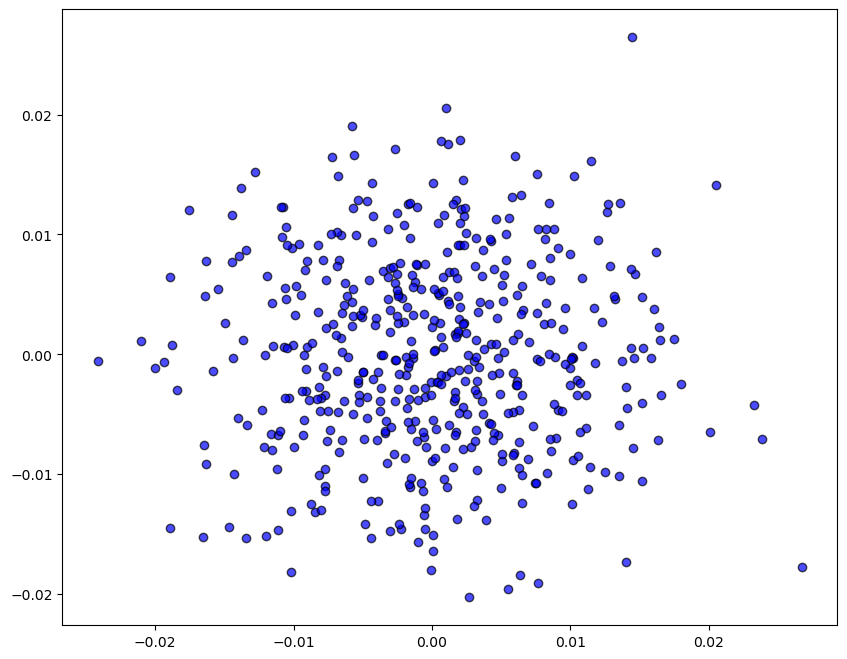

In [400]:
# For 2D visualization, create a scatter plot and annotate each point with its corresponding word to provide context.
plt.figure(figsize=(10, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], color='blue', alpha=0.7, edgecolor='k')


# For 3D visualization, use interactive plotting tools like matplotlib’s Axes3D to explore the spatial relationships between words dynamically.

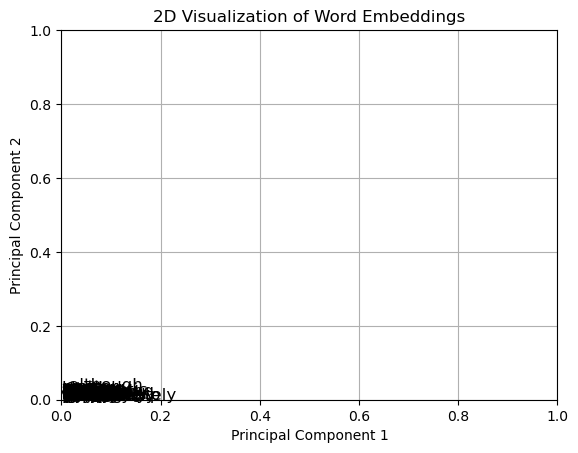

In [401]:
# Examine the resulting visualization for patterns.
# Look for clusters of similar words, such as synonyms or words with similar sentiment,
# Observe the distances between opposite terms.
# Demonstrate how word vectors capture semantic relationships.

# Annotate each point with its word
for i, word in enumerate(selected_words_filtered):
    plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=12)

plt.title("2D Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

Explained variance by components: [0.02018182 0.01932548 0.01870561]


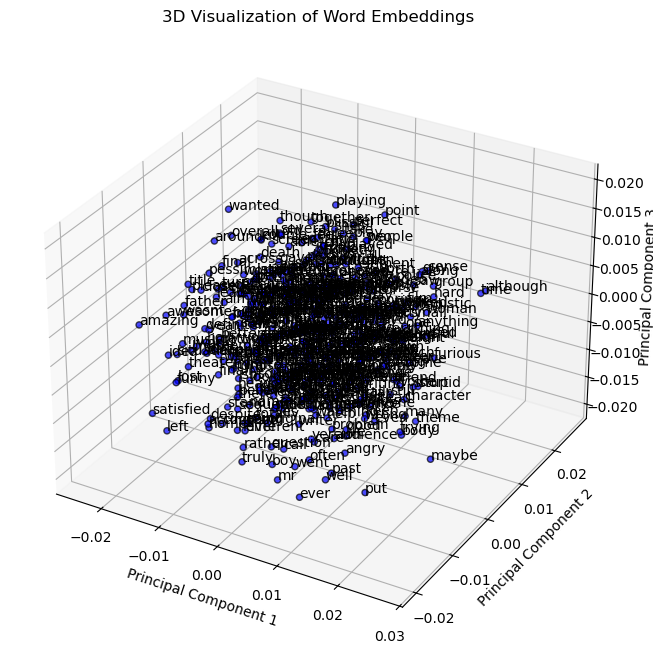

In [402]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA for 3D reduction
pca_3d = PCA(n_components=3)
reduced_vectors_3d = pca_3d.fit_transform(word_vectors)

# Check explained variance ratio
explained_variance2 = pca_3d.explained_variance_ratio_
print(f"Explained variance by components: {explained_variance2}")

# 3D Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_vectors_3d[:, 0], reduced_vectors_3d[:, 1], reduced_vectors_3d[:, 2], c='blue', alpha=0.7, edgecolor='k')

# Annotate points
for i, word in enumerate(selected_words_filtered):
    ax.text(reduced_vectors_3d[i, 0], reduced_vectors_3d[i, 1], reduced_vectors_3d[i, 2], word, fontsize=10)

ax.set_title("3D Visualization of Word Embeddings")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()

In [403]:
from numpy.linalg import norm

word1, word2 = "good", "bad"
distance = norm(fasttext_vectors[word1] - fasttext_vectors[word2])
print(f"Distance between '{word1}' and '{word2}': {distance:.4f}")
word1, word2 = "love", "hate"
distance = norm(fasttext_vectors[word1] - fasttext_vectors[word2])
print(f"Distance between '{word1}' and '{word2}': {distance:.4f}")
word1, word2 = "bad", "hate"
distance = norm(fasttext_vectors[word1] - fasttext_vectors[word2])
print(f"Distance between '{word1}' and '{word2}': {distance:.4f}")

Distance between 'good' and 'bad': 0.7569
Distance between 'love' and 'hate': 0.8862
Distance between 'bad' and 'hate': 1.3115


### 4. Creating the Emebdding Matrix (10 points)

In [404]:
# Define a function to create an embedding matrix
def create_embedding_matrix(word2vec, vocab, embedding_dim):
    vocab_size = len(vocab) + 1  # +1 for padding index (index 0)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, idx in vocab.items():
        if word in word2vec:
            embedding_matrix[idx] = word2vec[word]
        else:
            embedding_matrix[idx] = np.random.uniform(-0.01, 0.01, embedding_dim)  # Random initialization for OOV words

    return embedding_matrix

# Create a matrix where each row corresponds to the vector representation of a word in the vocabulary
# The embedding matrix will have dimensions [vocab_size, embedding_dim], where embedding_dim is the size of the word vectors

In [405]:
# Convert the embedding matrix to a PyTorch tensor
# You can create the embedding layer in here or directly in the model
# Using PyTorch’s nn.Embedding.from_pretrained method you load the pre-trained embedding matrix into the embedding layer

# Assuming 'vocabulary' is a dictionary where keys are words and values are indices
embedding_dim = 300  # Embedding vector size from FastText
embedding_matrix = create_embedding_matrix(reduced_vectors, vocabulary, embedding_dim)

# Convert the embedding matrix to a PyTorch tensor
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

# Create an embedding layer using the pre-trained embedding matrix
embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)  # Set freeze=True to prevent fine-tuning
print("Embedding layer created.")

# Example usage of the embedding layer
# Assume padded_sequences is a tensor of padded indices for the input text
padded_sequences = torch.tensor([
    [1, 2, 3, 0, 0],  # Example sequence
    [4, 5, 0, 0, 0]   # Another sequence
])

# Get the embedding representations for the padded sequences
embedded_output = embedding_layer(padded_sequences)
print("Embedded output shape:", embedded_output.shape)  # [batch_size, seq_length, embedding_dim]

Embedding layer created.
Embedded output shape: torch.Size([2, 5, 300])


Setting freeze=False allows the embedding layer to be updated during training, enabling the model to fine-tune the word embeddings to better fit the specific task. This is useful when you want the model to learn task-specific nuances in word meanings. If freeze=True, the embeddings remain fixed, which can save computation time but limits the model's ability to adapt to the task.

### 5. Implementing the IMDBDataset (5 points)
* Use PyTorch’s Dataset and DataLoader classes to manage the dataset efficiently and create mini-batches for training.

In [406]:
# Train, validation and test split

In [407]:
# Implement the dataset class
# Combine the padded sequences and corresponding sentiment labels into a dataset structure compatible with PyTorch.

# Implement the custom Dataset class
class IMDBDataset(Dataset):
    def __init__(self, padded_sequences, labels):
        """
        Args:
            padded_sequences: Tensor of padded sequences (shape: [num_samples, seq_length]).
            labels: Tensor of sentiment labels (shape: [num_samples]).
        """
        self.padded_sequences = torch.tensor(padded_sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Returns:
            A tuple (sequence, label) for the given index.
        """
        return self.padded_sequences[idx], self.labels[idx]

In [408]:
# Assume `padded_indices` and `sentiment_labels` are prepared from previous steps
# Split the dataset into train, validation, and test sets
dataset = IMDBDataset(padded_indices, sentiment_labels)
dataset_size = len(dataset)

train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [409]:
# Create the train, validation and test dataLoaders

# Create DataLoaders for batching
batch_size = 32  # Adjust batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset sizes - Train: {len(train_loader.dataset)}, Validation: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")

Dataset sizes - Train: 7000, Validation: 2000, Test: 1000


### 6. Implementing and Optimizing the Custom LSTM model (40 points)

In [410]:
def save_model(model, filename):
    # 'models' klasörünü kontrol et, yoksa oluştur
    directory = "models"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Modeli kaydet
    filepath = os.path.join(directory, filename)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

In [411]:
# Manually implement the LSTM cell to understand its architecture and functionality.
# Implement forget, input, and output gates.
# Update the cell state and compute the hidden state for each time step.
# Explain your steps and usage of the gates
# Check assignment pdf for more detail on implementation tips

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # Forget gate weights and bias
        self.W_f = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))
        
        # Input gate weights and bias
        self.W_i = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.b_i = nn.Parameter(torch.zeros(hidden_size))
        
        # Output gate weights and bias
        self.W_o = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))
        
        # Candidate cell state weights and bias
        self.W_c = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        # Initialize weights using Xavier initialization
        nn.init.xavier_uniform_(self.W_f)
        nn.init.xavier_uniform_(self.W_i)
        nn.init.xavier_uniform_(self.W_o)
        nn.init.xavier_uniform_(self.W_c)

    def forward(self, x_t, h_prev, c_prev):
        # Concatenate input and previous hidden state
        combined = torch.cat((x_t, h_prev), dim=1)
        
        # Forget gate
        f_t = torch.sigmoid(torch.matmul(combined, self.W_f.T) + self.b_f)
        
        # Input gate
        i_t = torch.sigmoid(torch.matmul(combined, self.W_i.T) + self.b_i)
        
        # Cell state update
        c_t_candidate = torch.tanh(torch.matmul(combined, self.W_c.T) + self.b_c)
        c_t = f_t * c_prev + i_t * c_t_candidate
        
        # Output gate
        o_t = torch.sigmoid(torch.matmul(combined, self.W_o.T) + self.b_o)
        
        # Hidden state update
        h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t



In [412]:
# Build an LSTM layer by combining one or multiple LSTM cells to process a sequence.

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMLayer, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm_cells = nn.ModuleList([LSTMCell(input_size, hidden_size) for _ in range(num_layers)])

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        h = torch.zeros(batch_size, self.hidden_size)
        c = torch.zeros(batch_size, self.hidden_size)
        
        outputs = []

        for t in range(seq_len):
            for layer in self.lstm_cells:
                h, c = layer(x[:, t, :], h, c)
            outputs.append(h)
        
        return torch.stack(outputs, dim=1)


In [413]:
# Build an LSTM model. Integrate the embedding layer into the model architecture.
# The embedding layer will convert input indices (from padded sequences) into dense word vectors.
# Decide whether to freeze the embedding weights or allow them to be fine-tuned during training and explain your choice.
# These dense vectors are then passed to the LSTM layer for sequential processing.
# You can provide embedding_matrix as tensor to define embedding layer inside the model class
# Or if you have defined embedding layer before, you can directly use that inside the model class

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class SentimentLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size=1):
        super(SentimentLSTM, self).__init__()
        # Embedding Layer: Use pre-trained Word2Vec embeddings.
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        # Custom LSTM Layer
        self.lstm = LSTMLayer(input_size=embedding_matrix.size(1), hidden_size=hidden_size)
        
        # Fully Connected Layer (Sigmoid activation for binary classification)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass input through the embedding layer
        x_emb = self.embedding(x)
        
        # Get the LSTM layers output
        lstm_out = self.lstm(x_emb)
        
        # Use the last hidden state for classification
        output = self.fc(lstm_out[:, -1, :])
        
        return output.squeeze() 


In [414]:
embedding_matrix = torch.tensor(embedding_matrix)

In [415]:
# Define the hyperparameters and try to optimize your model by experimenting with these
input_size = embedding_matrix.size(1)  # Word2Vec embedding size
hidden_size = 128
output_size = 1  # Binary classification
learning_rate = 0.001
batch_size = 64
epochs = 50

For this project, the learning rate was set to 0.001, which is a commonly used starting point for optimization with the Adam optimizer. A smaller learning rate ensures more stable convergence, reducing the risk of overshooting the optimal solution. After experimentation with different values, 0.001 provided a good balance between convergence speed and performance.

The batch size was chosen as 64 to balance between computational efficiency and model performance. A smaller batch size allows the model to update weights more frequently, which can help with convergence, but it may introduce noise into the gradient updates. A larger batch size smooths the gradients but requires more memory. Through trial and error, 64 was found to provide an effective compromise.

In [ ]:
# Define appropriate loss function for binary classification.
# Choose an optimizer and set its parameters (e.g., learning rate).
# Explain your choice of loss function and optimization algorithm.

# Create the model
model = SentimentLSTM(embedding_matrix, hidden_size)
model = model.float()  # Set the model to use float data type

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize the weights of the model
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LSTM):
        for name, param in module.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

# Apply the weight initialization function to the model
model.apply(initialize_weights)


SentimentLSTM(
  (embedding): Embedding(73250, 300)
  (lstm): LSTMLayer(
    (lstm_cells): ModuleList(
      (0): LSTMCell()
    )
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

- **BCEWithLogitsLoss**: Used for binary classification tasks. It combines the sigmoid activation and binary cross-entropy loss in one function, providing numerical stability by applying the sigmoid to logits directly.

- **Adam Optimizer**: A popular optimizer that adapts learning rates for each parameter using momentum and adaptive learning, making it effective for complex models like LSTMs.

- **Weight Decay**: Applied to the optimizer to prevent overfitting by penalizing large weights, improving the model's generalization ability.

In summary, `BCEWithLogitsLoss` is ideal for binary classification, and Adam with weight decay is efficient for training deep models and controlling overfitting.

In [417]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance

# Training Loop
train_losses = []
valid_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        
        # Limit gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct / total

    # Evaluate the model on the validation set
    model.eval()
    valid_loss, valid_correct, valid_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            valid_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            valid_correct += (preds == labels).sum().item()
            valid_total += labels.size(0)

    valid_losses.append(valid_loss / len(val_loader))
    valid_accuracy = valid_correct / valid_total

    print(f"Epoch {epoch}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

Epoch 0/50, Train Loss: 0.6932, Validation Loss: 0.6928, Train Accuracy: 0.5046, Validation Accuracy: 0.5085
Epoch 1/50, Train Loss: 0.7116, Validation Loss: 0.6936, Train Accuracy: 0.5250, Validation Accuracy: 0.5070
Epoch 2/50, Train Loss: 0.6557, Validation Loss: 0.7283, Train Accuracy: 0.5539, Validation Accuracy: 0.5120
Epoch 3/50, Train Loss: 0.6346, Validation Loss: 0.7188, Train Accuracy: 0.5550, Validation Accuracy: 0.5105
Epoch 4/50, Train Loss: 0.6320, Validation Loss: 0.7191, Train Accuracy: 0.5446, Validation Accuracy: 0.5035
Epoch 5/50, Train Loss: 0.6266, Validation Loss: 0.7184, Train Accuracy: 0.5497, Validation Accuracy: 0.5250
Epoch 6/50, Train Loss: 0.5569, Validation Loss: 0.4937, Train Accuracy: 0.6660, Validation Accuracy: 0.7990
Epoch 7/50, Train Loss: 0.3355, Validation Loss: 0.4027, Train Accuracy: 0.8679, Validation Accuracy: 0.8275
Epoch 8/50, Train Loss: 0.1763, Validation Loss: 0.4630, Train Accuracy: 0.9431, Validation Accuracy: 0.8250
Epoch 9/50, Train L

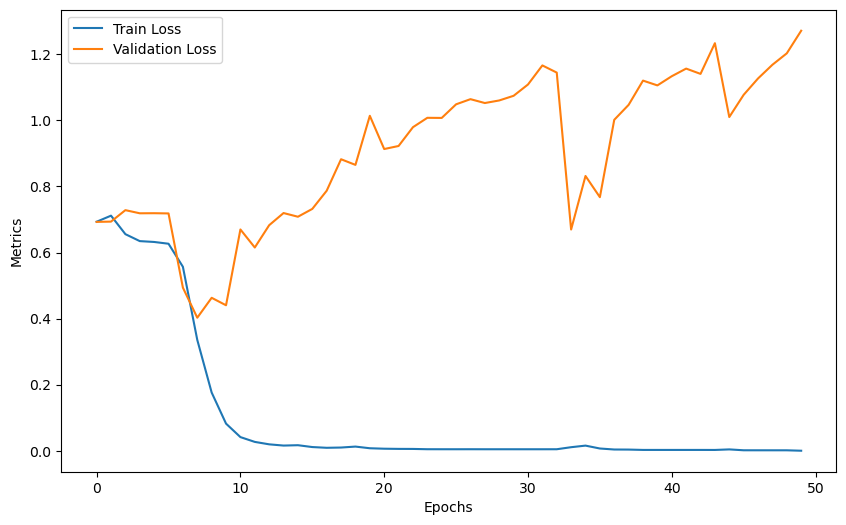

In [418]:
# Visualize the accuracy and loss change of the best model across training and validation datasets
# Make comments on the results

# Kayıpların ve doğrulukların görselleştirilmesi
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

### 7. Testing and Analysis (15 points)

In [419]:
# Test the best model on the test set to evaluate its performance.
# Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
# Explain and analyze your findings and results.
# Summarize the performance of the model on the training, validation and test set. Comment on the results.
# Discuss any challenges encountered during training and potential areas for improvement.


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Test metriklerinin hesaplanması
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)

print(f"Test Set Performance:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}")


Test Set Performance:
Accuracy: 0.8060
Precision: 0.7732
Recall: 0.8525
F1-Score: 0.8109


These results indicate that the model is reasonably effective in classifying sentiments, with strong recall suggesting it captures most of the positive instances. However, slightly lower precision indicates some false positives, which could be improved.

In [420]:
save_model(model, "sentiment_lstm.pth")

Model saved to models/sentiment_lstm.pth


#### Comparison with the Pytorch LSTM model (Optional)

In [421]:
# Implement sentiment LSTM model using PyTorch's built-in LSTM layer
# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

# Implement sentiment LSTM model using PyTorch's built-in LSTM layer
class PyTorchLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size, embedding_matrix):
        super(PyTorchLSTM, self).__init__()
        # Define embedding layer with pre-trained embeddings
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        # Use PyTorch's built-in LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        
        # Fully connected layer for binary classification
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Sigmoid activation for binary output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convert word indices to word vectors
        x_emb = self.embedding(x)
        
        # LSTM processing
        lstm_out, (h_n, c_n) = self.lstm(x_emb)
        
        # Use the last hidden state for classification
        last_hidden_state = h_n[-1]
        
        # Pass through the fully connected layer and apply sigmoid activation
        output = self.sigmoid(self.fc(last_hidden_state))

        output = output.squeeze()
        
        return output


In [422]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance

# Define parameters
embedding_dim = embedding_matrix.size(1)  # Dimension of pre-trained embeddings
hidden_size = 128  # Number of hidden units in LSTM
output_size = 1  # Binary classification output
learning_rate = 0.001
batch_size = 64
epochs = 50

# Initialize the PyTorch LSTM model
pytorch_lstm_model = PyTorchLSTM(embedding_dim, hidden_size, output_size, embedding_matrix).float()

# Define criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(pytorch_lstm_model.parameters(), lr=learning_rate)

# Training loop for PyTorch LSTM model
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(epochs):
    pytorch_lstm_model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        outputs = pytorch_lstm_model(inputs).squeeze(1)  # Squeeze to match labels dimension
        
        # Compute loss
        loss = criterion(outputs, labels.float())
        epoch_loss += loss.item()
        
        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        predictions = (outputs > 0.5).int()  # Binarize outputs
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)
    
    # Record training loss and accuracy
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Validation
    pytorch_lstm_model.eval()
    valid_loss = 0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = pytorch_lstm_model(inputs).squeeze(1)
            loss = criterion(outputs, labels.float())
            valid_loss += loss.item()
            
            # Compute validation accuracy
            predictions = (outputs > 0.5).int()
            correct_valid += (predictions == labels).sum().item()
            total_valid += labels.size(0)

    valid_losses.append(valid_loss / len(val_loader))
    valid_accuracies.append(correct_valid / total_valid)

    # Print metrics
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}")


Epoch 1/50, Train Loss: 0.6934, Validation Loss: 0.6927, Train Accuracy: 0.5013, Validation Accuracy: 0.5125
Epoch 2/50, Train Loss: 0.6831, Validation Loss: 0.7004, Train Accuracy: 0.5403, Validation Accuracy: 0.5070
Epoch 3/50, Train Loss: 0.6375, Validation Loss: 0.7247, Train Accuracy: 0.5500, Validation Accuracy: 0.5095
Epoch 4/50, Train Loss: 0.6252, Validation Loss: 0.7608, Train Accuracy: 0.5503, Validation Accuracy: 0.5125
Epoch 5/50, Train Loss: 0.6231, Validation Loss: 0.7704, Train Accuracy: 0.5524, Validation Accuracy: 0.5090
Epoch 6/50, Train Loss: 0.6210, Validation Loss: 0.7648, Train Accuracy: 0.5473, Validation Accuracy: 0.5110
Epoch 7/50, Train Loss: 0.6203, Validation Loss: 0.7655, Train Accuracy: 0.5581, Validation Accuracy: 0.5080
Epoch 8/50, Train Loss: 0.6178, Validation Loss: 0.7769, Train Accuracy: 0.5589, Validation Accuracy: 0.5110
Epoch 9/50, Train Loss: 0.6178, Validation Loss: 0.8032, Train Accuracy: 0.5454, Validation Accuracy: 0.5015
Epoch 10/50, Train 

In [423]:
# Define parameters
# Define criterion and optimizer
# Train PyTorch LSTM model

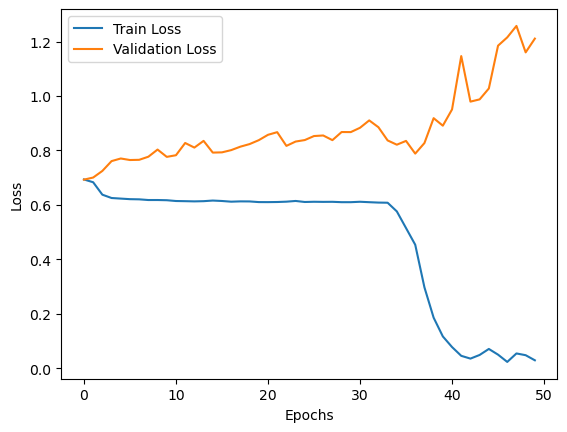

PyTorch LSTM Test Performance:
Accuracy: 0.7200
Precision: 0.7088
Recall: 0.7234
F1-Score: 0.7160


In [424]:
# Compare the performance of your custom LSTM model with PyTorchLSTM model

# Visualize the training and validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Compare the performance of the custom LSTM model with PyTorchLSTM model
pytorch_lstm_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = pytorch_lstm_model(inputs)
        preds = (outputs > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"PyTorch LSTM Test Performance:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}")

In [425]:
save_model(pytorch_lstm_model, "pytorch_lstm.pth")

Model saved to models/pytorch_lstm.pth


In [427]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import numpy as np

# Step 1: Load the test data
test_file_path = './subset1000_IMDB_Dataset.csv'  # Adjust this to the test dataset file path
test_data = pd.read_csv(test_file_path)

# Predefine tokenizer and other preprocessing utilities (reuse from training)

# Step 2: Preprocess the test data, apply the steps used during training (change according to your implementation)
test_data["cleaned_tokens"] = test_data["review"].apply(preprocess_text)
test_data["indices"] = test_data["cleaned_tokens"].apply(tokenizer.texts_to_sequences)
test_data["padded_indices"] = test_data["indices"].apply(lambda x: pad_sequence(x, padding_length)) # Replace with the maximum sequence length used during training

# Convert the padded indices into a tensor
padded_test = np.array(test_data['padded_indices'].tolist())

print(f"Padded test data shape: {padded_test.shape}")

# Convert to PyTorch tensor
test_tensor = torch.tensor(padded_test.squeeze(), dtype=torch.long)

# Step 3: Load the best-performing model
model_path = './models/sentiment_lstm.pth'  # Replace with your model's path

# Initialize the model
class SentimentLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size=1):
        super(SentimentLSTM, self).__init__()
        # Embedding Layer: Use pre-trained Word2Vec embeddings.
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        # Custom LSTM Layer
        self.lstm = LSTMLayer(input_size=embedding_matrix.size(1), hidden_size=hidden_size)
        
        # Fully Connected Layer (Sigmoid activation for binary classification)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass input through the embedding layer
        x_emb = self.embedding(x)
        
        # Get the LSTM layers output
        lstm_out = self.lstm(x_emb)
        
        # Use the last hidden state for classification
        output = self.fc(lstm_out[:, -1, :])
        
        return output.squeeze()

model = SentimentLSTM(embedding_matrix.float(), hidden_size)

# Load the state dict into the model
model.load_state_dict(torch.load(model_path))
model.eval()

# Step 4: Predict sentiment for the test reviews
batch_size = 32
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch)
        preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        preds = torch.round(preds).squeeze().tolist()  # Binarize predictions to 0 or 1
        predictions.extend(preds)

# Step 5: Map predicted class labels to corresponding class names
class_labels = {0: 'negative', 1: 'positive'}

# Step 6: Save predictions to CSV file
df = pd.DataFrame({'ID': range(1, len(predictions) + 1), 'sentiment': [class_labels[int(p)] for p in predictions]})
df.to_csv('predictions.csv', index=False)

Padded test data shape: (1000, 231, 1)


/var/folders/1c/btd9y82524l3cvhynxkxjn840000gn/T/ipykernel_1352/1585653363.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

Kaggle Score : 0.944